# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('/content/autos.csv')
display(df.info())
display(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
141781,2016-03-27 16:57:14,6750,bus,2009,manual,120,zafira,150000,5,gasoline,opel,no,2016-03-27 00:00:00,0,83301,2016-03-27 17:40:30
301490,2016-03-11 14:52:58,300,small,1996,manual,0,NaN,150000,4,petrol,citroen,yes,2016-03-11 00:00:00,0,59067,2016-04-05 11:48:43
214547,2016-03-16 18:36:45,1399,sedan,1996,auto,116,3er,150000,10,petrol,bmw,no,2016-03-16 00:00:00,0,51580,2016-04-07 02:16:03
216929,2016-03-09 21:58:38,7950,wagon,2004,auto,150,c_klasse,150000,10,gasoline,mercedes_benz,no,2016-03-09 00:00:00,0,24784,2016-03-29 16:47:02
345707,2016-03-15 18:51:59,8800,suv,2009,manual,177,x_reihe,150000,7,gasoline,bmw,yes,2016-03-15 00:00:00,0,89537,2016-03-15 18:51:59
196414,2016-03-16 20:25:23,8900,convertible,2013,auto,71,fortwo,30000,4,petrol,smart,no,2016-03-16 00:00:00,0,65187,2016-04-02 00:16:25
66965,2016-03-12 23:54:07,5800,small,2009,manual,90,fiesta,150000,4,gasoline,ford,no,2016-03-12 00:00:00,0,37539,2016-04-06 13:45:46
159482,2016-03-15 15:53:23,17500,convertible,2011,auto,184,cooper,30000,2,petrol,mini,no,2016-03-15 00:00:00,0,1326,2016-04-06 08:16:10
25982,2016-03-25 23:58:27,3790,wagon,2004,manual,150,3er,150000,10,gasoline,bmw,no,2016-03-25 00:00:00,0,76131,2016-03-31 02:15:34
350316,2016-03-25 12:48:16,10500,bus,2008,manual,150,vito,150000,3,gasoline,mercedes_benz,no,2016-03-25 00:00:00,0,88079,2016-03-25 12:48:16


In [9]:
df.columns.str.lower()
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']


В нашем датасете есть небольшое кол-во пропусков, далее посмотрим какой процент они составляют и определимся, что с ними делать. Описание столбцов:
* date_crawled — дата скачивания анкеты из базы
* vehicle_type — тип автомобильного кузова
* registration_year — год регистрации автомобиля
* gearbox — тип коробки передач
* power — мощность (л. с.)
* model — модель автомобиля
* kilometer — пробег (км)
* registration_month — месяц регистрации автомобиля
* fuel_type — тип топлива
* brand — марка автомобиля
* not_repaired — была машина в ремонте или нет
* date_created — дата создания анкеты
* number_of_pictures — количество фотографий автомобиля
* postal_code — почтовый индекс владельца анкеты (пользователя)
* last_seen — дата последней активности пользователя

Проверим сколько в наших данным пропусков и есть ли дубликаты

In [10]:
display(df.isna().mean())
display('Кол-во дубликатов', df.duplicated().sum())

date_crawled          0.000000
price                 0.000000
vehicle_type          0.105794
registration_year     0.000000
gearbox               0.055967
power                 0.000000
model                 0.055606
kilometer             0.000000
registration_month    0.000000
fuel_type             0.092827
brand                 0.000000
not_repaired          0.200791
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

'Кол-во дубликатов'

4

In [11]:
df = df.drop_duplicates()
display('Кол-во дубликатов', df.duplicated().sum())

'Кол-во дубликатов'

0

In [12]:
df = df.drop(['number_of_pictures', 'last_seen','postal_code', 'date_crawled', 'registration_month','date_created'], axis=1)

Мы удалили лишние столбцы, так как они были не информативны и могли помешать обучению нашей модели

In [13]:
df.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


Предварительную предобработку мы сделали, посмотрим есть ли у нас аномальные данные. Есть вероятность, что мы что-то найдем, так как в 7 строке мы уже видим стоимость автомобиля 0, обычно автомобили даром не отдают. Аномальные данные мы удалим, так как заполнить их верно мы не можем

In [14]:
df['registration_year'].describe(percentiles = [0, .05, .10, .15, .20, .25, .50, .75, .80, .85, .90, .95])

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
0%         1000.000000
5%         1992.000000
10%        1995.000000
15%        1997.000000
20%        1998.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
80%        2009.000000
85%        2010.000000
90%        2012.000000
95%        2016.000000
max        9999.000000
Name: registration_year, dtype: float64

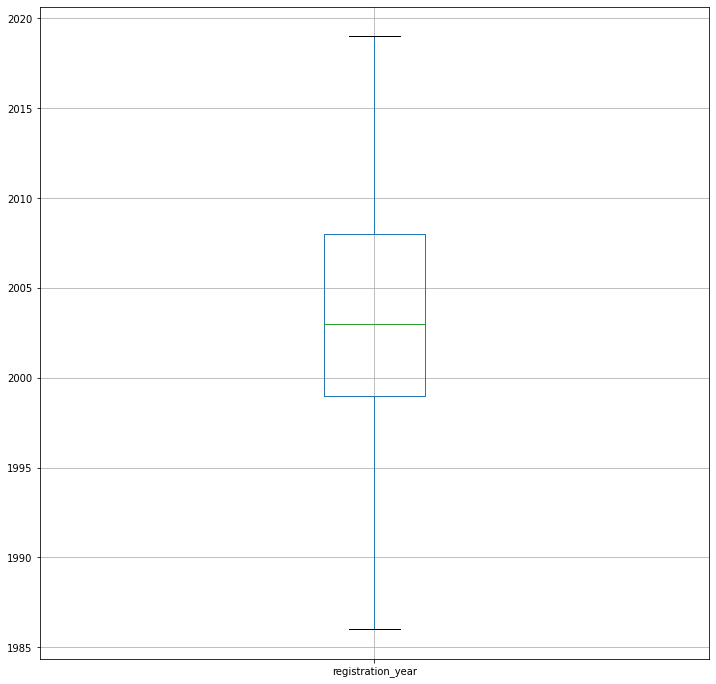

In [15]:
df.boxplot(column=['registration_year'], figsize=(12,12), showfliers=False)

Очевидно, что автомобили зарегистрированные в 1000 году это аномалия, поэтому отсечем наш датасет по 0,5 и 0,95 квартилям.

In [16]:
df = df.query('1992 <= registration_year <= 2016')

In [17]:
len(df)

324598

In [18]:
df['power'].describe(percentiles = [0, .05, .10, .15, .20, .25, .50, .75, .80, .85, .90, .95])

count    324598.000000
mean        112.156754
std         183.674678
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          55.000000
20%          60.000000
25%          71.000000
50%         105.000000
75%         143.000000
80%         150.000000
85%         170.000000
90%         184.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64

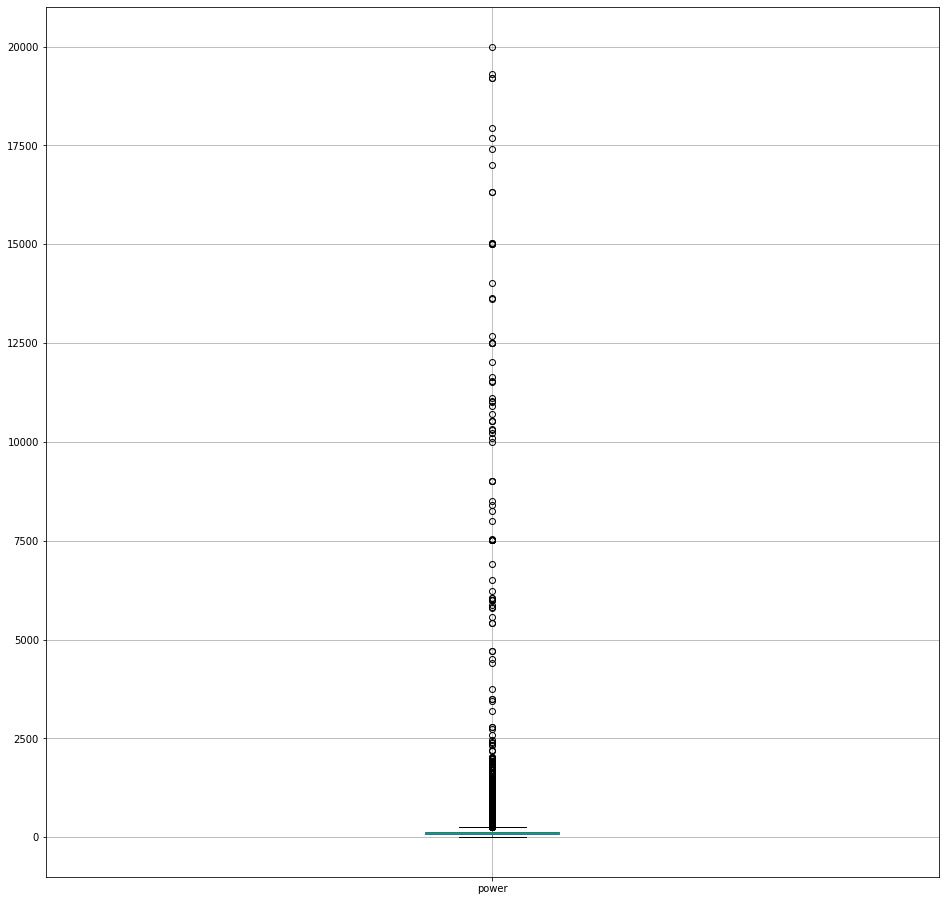

In [19]:
df.boxplot(column=['power'], figsize=(16,16))

In [20]:
df.query('power == 44').head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
2516,350,small,1993,manual,44,corsa,150000,petrol,opel,no
3017,250,small,2001,manual,44,fiesta,150000,petrol,ford,yes
3398,650,NaN,2016,manual,44,NaN,150000,NaN,peugeot,yes
4454,500,small,2000,manual,44,fiesta,150000,petrol,ford,yes
4970,700,small,1999,manual,44,lupo,150000,petrol,volkswagen,no


Исходя из графика мы откинем выбросы до 44 л.с и все, что больше 2500 л.с. Как гласит википедия автомобили с маленькими двигателями выпускались с 1982 года, например, opel corca. Именно такие автомобили и попадались в наших данных.
https://ru.wikipedia.org/wiki/Opel_Corsa

In [21]:
df = df.query('44 <= power <= 2500')

In [22]:
len(df)

290137

In [23]:
df['price'].describe(percentiles = [0, .05, .10, .15, .20, .25, .50, .75, .80, .85, .90, .95])

count    290137.000000
mean       4789.674016
std        4623.940243
min           0.000000
0%            0.000000
5%          300.000000
10%         599.000000
15%         800.000000
20%        1000.000000
25%        1270.000000
50%        3049.000000
75%        6989.000000
80%        8200.000000
85%        9850.000000
90%       11999.000000
95%       14999.000000
max       20000.000000
Name: price, dtype: float64

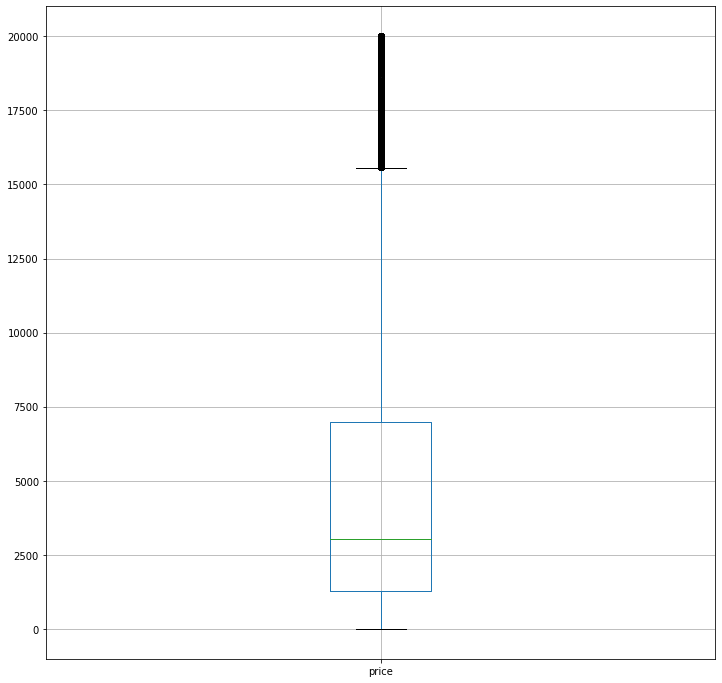

In [24]:
df.boxplot(column=['price'], figsize=(12,12))

Автомобили с нулевой стоимостью это не порядок, стоит их убрать. Также у нас есть выбросы по стоимости, их лучше убрать.

In [25]:
df = df.query('300 <= price <= 15500')

In [26]:
len(df)

264630

Итог, после отсечения аномалий мы получили датасет почти из 25 тыс. строк. Так как у нас много категорийных признаков, которые имееют строковые значения, применим метод кодирование OHE

In [27]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,...,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
2,9800,2004,163,125000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
features = df_ohe.drop('price', axis = 1)
target = df_ohe['price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=29)

In [29]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(198472, 302) (66158, 302) (198472,) (66158,)


Во избежание влияния дисбаланса классов уравновесим их с помощью метода StandardScaler

In [30]:
scaler = StandardScaler()
scaler.fit(features_train[['power', 'kilometer']])
features_train[['power', 'kilometer']] = scaler.transform(features_train[['power', 'kilometer']])
features_test[['power', 'kilometer']] = scaler.transform(features_test[['power', 'kilometer']])

## Обучение моделей

Для оценки наших моделей будем использовать метрику RMSE(среднеквадратичное отклонение).

In [31]:
def RMSE(target, predict):
    return mean_squared_error(target,predict)**0.5

In [32]:
score = make_scorer(RMSE, greater_is_better=False)

Чтобы улучшить работу моделей, применик кросс-валидацию, а именно воспользуемся методом ShuffleSplit. Будем делить данные на 5 подвыборок.

In [33]:
cross_val = ShuffleSplit(n_splits=5, test_size=0.25, random_state=29)

### Линейная регрессия

Для начала используем простую модель линейной регресси и посмотрим на ее результаты

In [34]:
LinearReg_model = LinearRegression()

In [35]:
%%time
LinearReg_model.fit(features_train, target_train)

CPU times: user 11.6 s, sys: 910 ms, total: 12.5 s
Wall time: 6.93 s


LinearRegression()

In [36]:
%%time
LinReg_predictions = LinearReg_model.predict(features_test)

CPU times: user 107 ms, sys: 48.8 ms, total: 155 ms
Wall time: 99.7 ms


In [37]:
print('RMSE: ', RMSE(target_test, LinReg_predictions).round(2))

RMSE:  2077.52


Модель линейной регресси работает очень быстро, качество предсказания неплохое, проверим насколько можно уменьшить метрику используя градиентный бустинг

### Catboost

In [38]:
CBRegressor_model = CatBoostRegressor(verbose = 10, random_seed = 29)

In [39]:
param_grid = {'iterations': [10, 50], 'max_depth': [5, 15]}

In [40]:
grid_cv = GridSearchCV(CBRegressor_model, param_grid, scoring=score, cv=cross_val)

In [41]:
%%time
grid_cv.fit(features_train, target_train, verbose=False)

CPU times: user 4min 52s, sys: 1min 23s, total: 6min 16s
Wall time: 3min 29s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=29, test_size=0.25, train_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe1727248d0>,
             param_grid={'iterations': [10, 50], 'max_depth': [5, 15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [42]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-1330.7729336821687
{'iterations': 50, 'max_depth': 15}


In [43]:
CBRegressor_model = CatBoostRegressor(verbose = 10, iterations = 50, max_depth = 15)

In [44]:
%%time
CBRegressor_model.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 2477.0228839	total: 549ms	remaining: 26.9s
10:	learn: 1374.2860249	total: 5.66s	remaining: 20.1s
20:	learn: 1309.3882678	total: 10.8s	remaining: 14.8s
30:	learn: 1267.4912261	total: 15.9s	remaining: 9.73s
40:	learn: 1238.3949457	total: 20.9s	remaining: 4.6s
49:	learn: 1219.5468795	total: 25.5s	remaining: 0us
CPU times: user 37.6 s, sys: 11.8 s, total: 49.4 s
Wall time: 26.7 s


In [45]:
%%time
CB_predictions = CBRegressor_model.predict(features_test)

CPU times: user 122 ms, sys: 12.1 ms, total: 134 ms
Wall time: 86.2 ms


In [46]:
print('RMSE: ', RMSE(target_test, CB_predictions).round(2))

RMSE:  1313.89


Catboost справился гораздо дольше чем линейная регресси, но и качество предсказаний гораздо выше. Посмотрим как себя проявит LGBMRegresso

### LGBMRegressor

In [47]:
LGBMRegressor_model = LGBMRegressor(random_state = 29, n_job=-1)

In [48]:
LGBMRegressor_model

LGBMRegressor(n_job=-1, random_state=29)

In [49]:
param_grid = {'n_estimators': [100, 1000], 'max_depth': [5, 15]}

In [50]:
grid_cv = GridSearchCV(LGBMRegressor_model, param_grid, scoring=score, cv=cross_val)

In [51]:
%%time
grid_cv.fit(features_train, target_train, verbose=True)

CPU times: user 4min 9s, sys: 2.38 s, total: 4min 12s
Wall time: 2min 18s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=29, test_size=0.25, train_size=None),
             estimator=LGBMRegressor(n_job=-1, random_state=29),
             param_grid={'max_depth': [5, 15], 'n_estimators': [100, 1000]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [52]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-1299.2691829333917
{'max_depth': 15, 'n_estimators': 1000}


In [53]:
LGBMRegressor_model = LGBMRegressor(random_state = 29, max_depth= 15, n_estimators= 1000, n_job=-1)

In [54]:
%%time
LGBMRegressor_model.fit(features_train, target_train)

CPU times: user 19 s, sys: 199 ms, total: 19.2 s
Wall time: 10.1 s


LGBMRegressor(max_depth=15, n_estimators=1000, n_job=-1, random_state=29)

In [55]:
%%time
LGBM_predictions = LGBMRegressor_model.predict(features_test)

CPU times: user 5.92 s, sys: 9.62 ms, total: 5.93 s
Wall time: 3.13 s


In [56]:
print('RMSE: ', RMSE(target_test, LGBM_predictions).round(2))

RMSE:  1289.67


## Анализ моделей

Мы обучили 3 разные модели, сделаем выводы по полученным данным:

In [3]:
result=pd.DataFrame({'Модель':['LinearRegression', 'CatBoost', 'LGBMRegressor'],
 'Скорость подбора гиперпараметров':['Гиперпараметров нет', '3 мин 29 сек', '2 мин 18 сек'],
 'Скорость обучения':['6,93 сек', '26,7 сек', '10,1 сек'],
 'Скорость предсказания': ['99,7 мсек', '86,2 мсек', '3,13 сек'],
 'Качество предсказания(RMSE)': ['2077,52', '1313,89', '1289,67']})
result

,Модель,Скорость подбора гиперпараметров,Скорость обучения,Скорость предсказания,Качество предсказания(RMSE)
0,LinearRegression,Гиперпараметров нет,"6,93 сек","99,7 мсек","2077,52"
1,CatBoost,3 мин 29 сек,"26,7 сек","86,2 мсек","1313,89"
2,LGBMRegressor,2 мин 18 сек,"10,1 сек","3,13 сек","1289,67"


## Вывод

Мы провели сравнение трех моделей для магазина по продаже автомобилей с пробегом «Не бит, не крашен». Так как наш заказчит будет использовать модель для предсказания стоимости в своем мобильном приложении наша рекомендация использовать модель Catboost, не смотря на то, что модель LGBM точнее именно в мобильном приложении нам важна скорость предсказания. 